# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [114]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [115]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [116]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [117]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [118]:
n_chains = 2
n_edges_per_chain = 4
bar_radius = 1.2

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 200, 100, 100

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 1e-2,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 300
Number of faces: 592
SDF shape: (200, 100, 100)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

TODOs>
- fix bcs
- plot parts of jacobian for parameters
- scaling VN bcs instead of gradients in FD


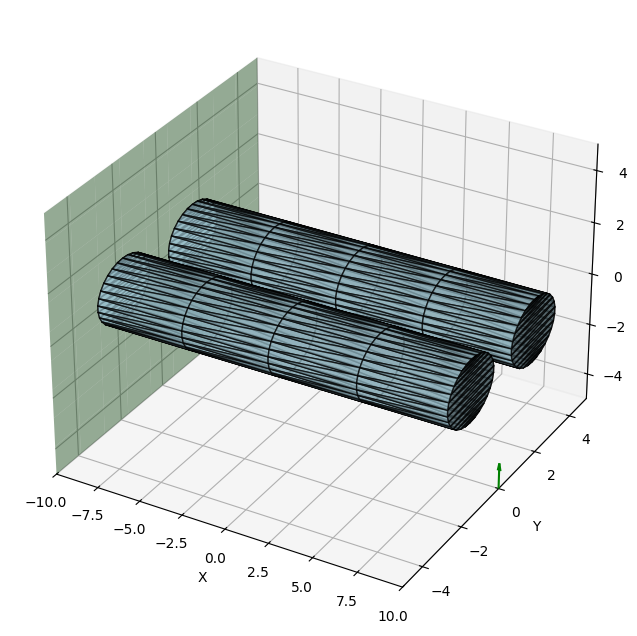

In [119]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

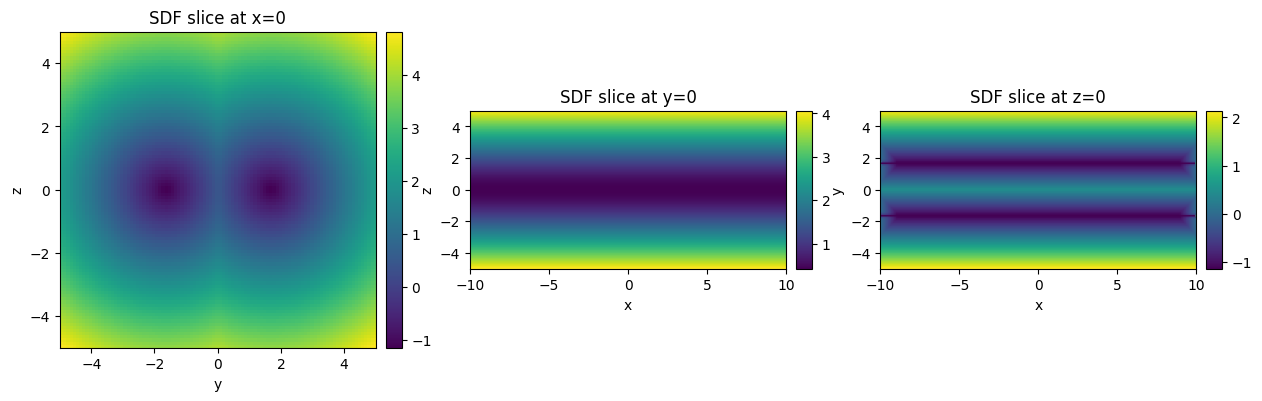

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [121]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params.flatten(),
#             **design_inputs,
#         },
#     )["sdf"],
#     initial_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [122]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, 0, 6)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     primal, vjp_fun = jax.vjp(
#         lambda params, eps=eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 "non_differentiable_parameters": jnp.array(
#                     [bar_radius], dtype=jnp.float32
#                 ),
#                 "static_parameters": [n_chains, n_edges_per_chain + 1],
#                 "string_parameters": [],
#                 "mesh_tesseract": TesseractReference(bar_3d_tess),
#                 "grid_size": [Lx, Ly, Lz],
#                 "grid_elements": [Nx, Ny, Nz],
#                 "grid_center": [0.0, 0.0, 0.0],
#                 "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
#                 "normalize_jacobian": True,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [123]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

rho min: 7.329537038458511e-05, rho max: 0.9157840013504028


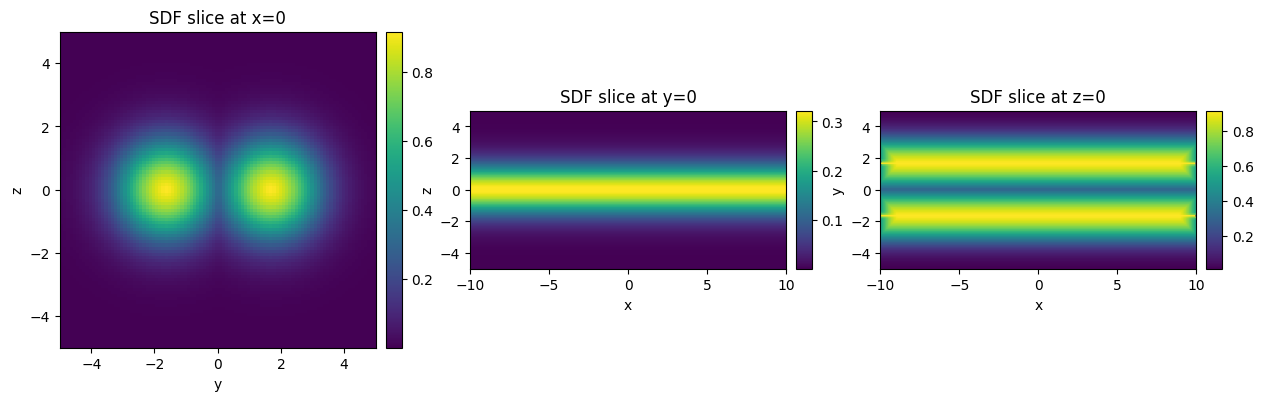

In [124]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


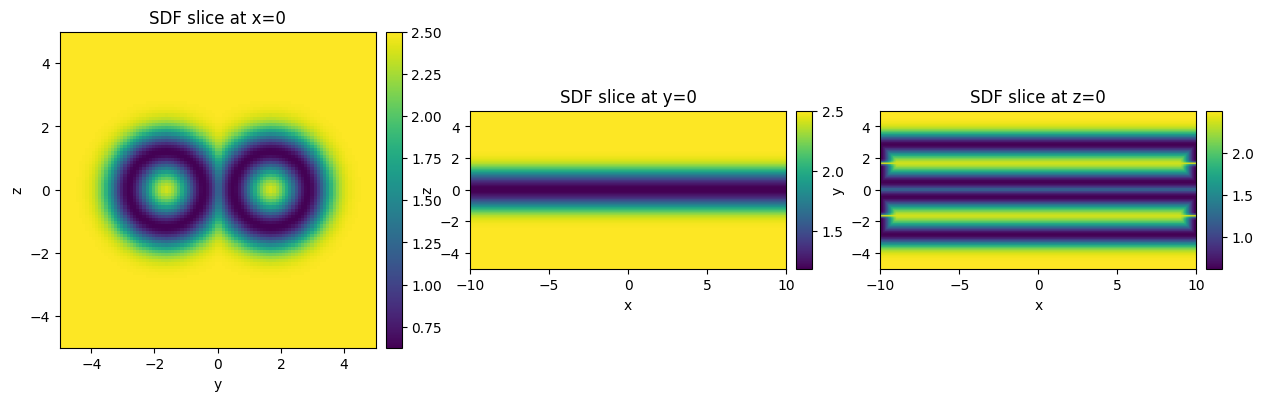

In [125]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [128]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Done building mesh
Mesh points: 10615, Mesh faces: 8736
0.8718262
(30000,)


Lets check the gradient of the meshing Tesseract

In [129]:
primal, vjp_fun = jax.vjp(
    lambda rho: apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,
            "field_values": rho,
            "max_subdivision_levels": 3,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )["mesh_cell_values"],
    rho,
)

grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

print("Gradient shape:", grad.shape)
print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Done building mesh
Done building mesh
Gradient shape: (200, 100, 100)
Max grad: 0.010416698642075062, Min grad: 0.00011533882934600115


Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [130]:
# Lets export it to a .vtk using pyvista
import numpy as np
import pyvista as pv


def hex_to_pyvista(
    pts: jax.typing.ArrayLike, faces: jax.typing.ArrayLike, cell_data: dict
) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).
        cell_data: additional cell center data.

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    pts = np.array(pts)
    faces = np.array(faces)

    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    mesh = pv.UnstructuredGrid(cells, cell_types, pts)

    # Add cell data
    for name, data in cell_data.items():
        mesh.cell_data[name] = data

    return mesh


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"][: adaptive_mesh["n_points"]])
cells_np = np.array(adaptive_mesh["faces"][: adaptive_mesh["n_faces"]])

hex_mesh = hex_to_pyvista(
    pts_np,
    cells_np,
    {"rho": mesher_out["mesh_cell_values"][: adaptive_mesh["n_faces"]]},
)

print(hex_mesh)

hex_mesh.save("bars_mesh.vtk")

UnstructuredGrid (0x71014f8b9ea0)
  N Cells:    8736
  N Points:   10615
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


## Boundary Conditions

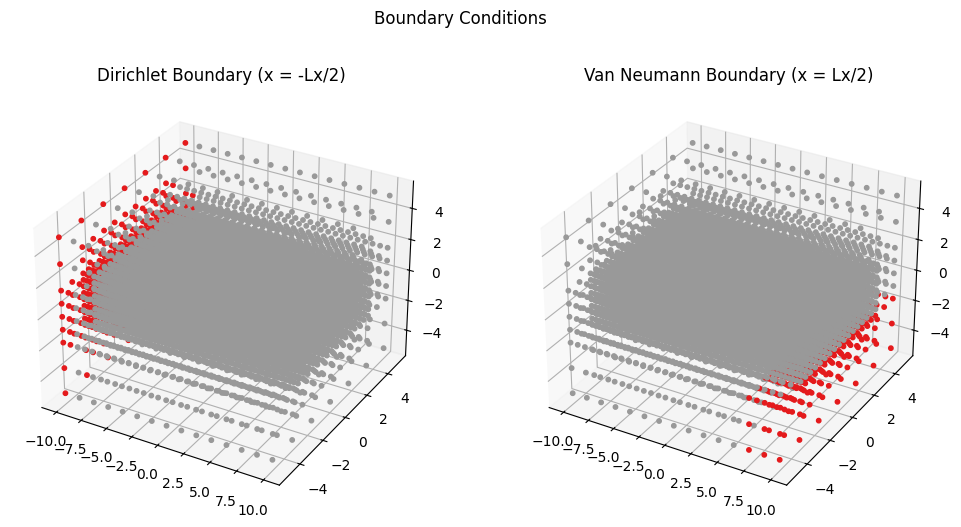

In [131]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [132]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [133]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 1.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-20 15:54:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:54:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:54:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-20 15:54:24][DEBUG] jax_fem: Done pre-computations, took 2.219184398651123 [s]
[11-20 15:54:24][INFO] jax_fem: Solving a problem with 8736 cells, 10615x3 = 31845 dofs.
[11-20 15:54:24][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:54:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:54:26][DEBUG] jax_fem: Start timing
[11-20 15:54:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:54:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.5820 seconds
[11-20 15:54:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:54:29][DEBUG] jax_fem: Before, l_2 res = 49.45016628561422, relative l_2 res = 1.0
[11-20 15:54:29][DEBUG] jax_fem: Solving linear system...
[11-20 15:54:29][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-20 15:54:51][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.520629425160236e-09
[11-20 15:54:51][DEBUG] j

Compliance: 3447.2759


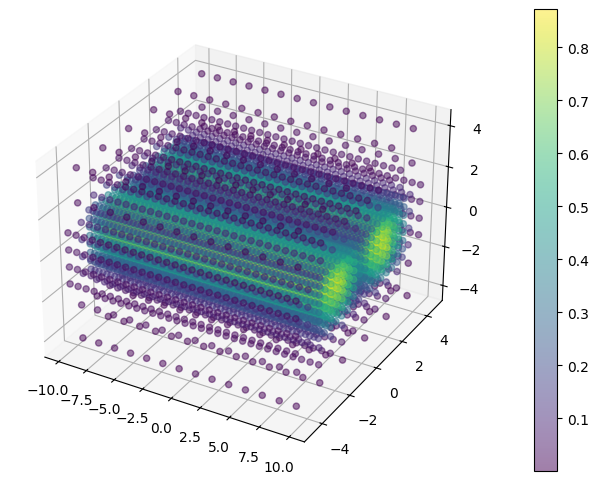

In [134]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [135]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)

In [136]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [140]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [141]:
grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [139]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Done building mesh


[11-20 15:54:54][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:54:54][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:54:54][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:54:55][DEBUG] jax_fem: Done pre-computations, took 1.1201648712158203 [s]
[11-20 15:54:55][INFO] jax_fem: Solving a problem with 2464 cells, 3199x3 = 9597 dofs.
[11-20 15:54:55][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:54:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:54:57][DEBUG] jax_fem: Start timing
[11-20 15:54:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:54:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.5509 seconds
[11-20 15:54:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:54:59][DEBUG] jax_fem: Before, l_2 res = 5.001482919423332, relative l_2 res

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
loss 31.54585075378418, grads [ 1.48136625e-02  2.94630200e-01 -4.93946895e-02 -1.73849880e-03
  3.45329583e-01 -1.15591511e-01  1.45256612e-03  3.67218614e-01
 -5.46479486e-02 -8.61566048e-04  3.73443663e-01  9.99342799e-02
 -4.36974131e-03  3.50171149e-01  2.36548036e-01  1.15876636e-02
  2.76098132e-01 -5.11404946e-02 -2.13478692e-03  3.48259330e-01
 -1.18145056e-01 -1.73476437e-04  1.51235193e-01 -5.35031706e-02
 -1.92553783e-03  6.14959225e-02  9.54333097e-02 -3.79191176e-03
  6.69345185e-02  2.27764696e-01]


In [142]:
print(jnp.max(grad_storage[1000][1]))
print(jnp.max(grad_storage[2000][1]))

0.0010698874
5.5123905e-10


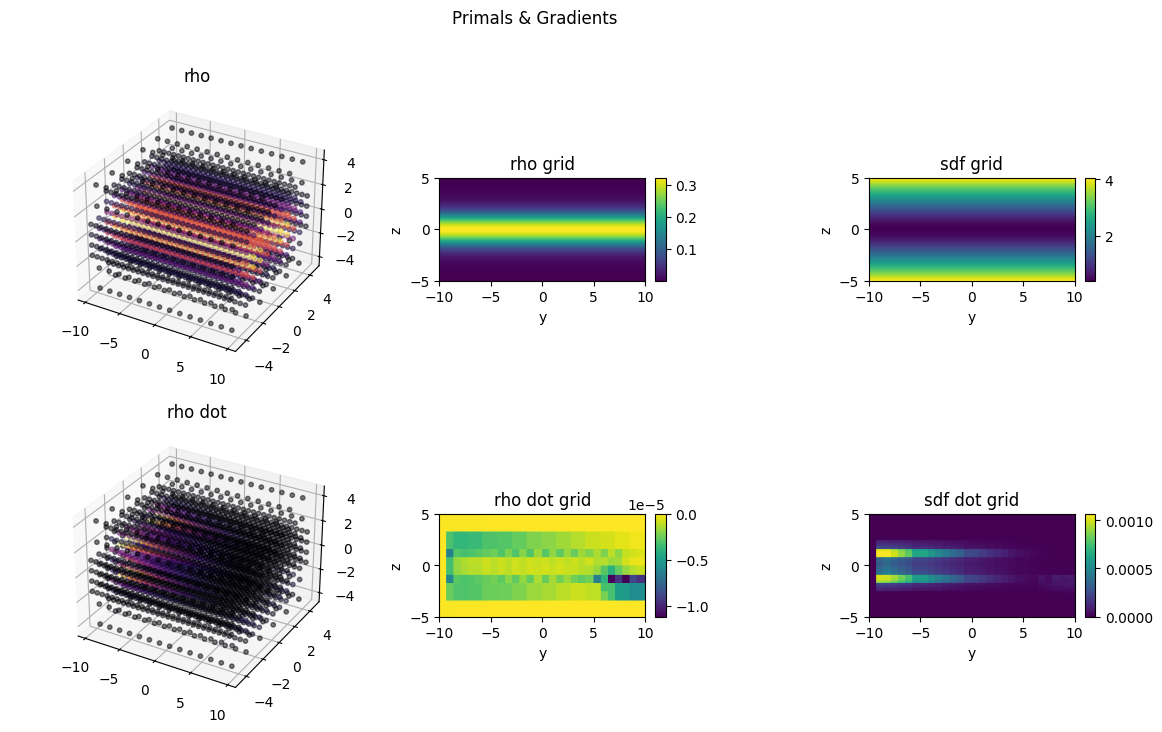

In [143]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = aux["hex_mesh"]

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=mesh["rho"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[3000][1][: mesh["rho"].shape[0]],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

In [144]:
import optax

n_steps = 30
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.3, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    aux_hist.append(aux)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # params = params.at[..., 0].set(initial_params[..., 0])  # fix x-coordinates

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[11-20 15:55:25][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:55:25][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:55:25][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


Done building mesh


[11-20 15:55:26][DEBUG] jax_fem: Done pre-computations, took 0.4409348964691162 [s]
[11-20 15:55:26][INFO] jax_fem: Solving a problem with 2464 cells, 3199x3 = 9597 dofs.
[11-20 15:55:26][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:55:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:55:26][DEBUG] jax_fem: Start timing
[11-20 15:55:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:55:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.3725 seconds
[11-20 15:55:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:55:27][DEBUG] jax_fem: Before, l_2 res = 5.001482919423332, relative l_2 res = 1.0
[11-20 15:55:27][DEBUG] jax_fem: Solving linear system...
[11-20 15:55:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-20 15:55:29][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.3490099050661138e-10
[11-20 15:55:29][DEBUG] j

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
[ 8.6157229e-03  2.9668090e-01 -5.0733875e-02  4.2204745e-04
  3.4523553e-01 -1.1304355e-01  8.3915214e-04  3.6436373e-01
 -5.3911753e-02 -1.4054894e-03  3.7441939e-01  1.0302901e-01
 -4.1557611e-03  3.4978116e-01  2.3660174e-01  1.0146346e-02
  2.7493376e-01 -5.0924089e-02  2.3376408e-03  3.4805432e-01
 -1.1592515e-01 -1.8432916e-03  1.5204245e-01 -5.4514054e-02
  2.1236957e-04  6.0556732e-02  9.6380666e-02 -3.1800636e-03
  6.5588616e-02  2.2970152e-01]
[-10.         -1.6666666   0.         -5.         -1.6666666   0.
   0.         -1.6666666   0.          5.         -1.6666666   0.
  10.         -1.6666666   0.        -10.          1.6666666   0.
  -5.          1.6666666   0.          0.          1.6666666   0.
   5.          1.6666666   0.         10.          1.6666666   0.       ]
Iteration 1, Loss: 31.5460
Done building mesh


[11-20 15:55:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:55:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:55:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:55:48][DEBUG] jax_fem: Done pre-computations, took 1.1290185451507568 [s]
[11-20 15:55:48][INFO] jax_fem: Solving a problem with 1897 cells, 2556x3 = 7668 dofs.
[11-20 15:55:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:55:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:55:50][DEBUG] jax_fem: Start timing
[11-20 15:55:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:55:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.5126 seconds
[11-20 15:55:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:55:52][DEBUG] jax_fem: Before, l_2 res = 5.027235830433784, relative l_2 res

Storing values in hash 3001
Done building mesh
Storing values in hash 2001
Storing values in hash 1001
Computing Jacobian...
[-0.05555905  0.06310438 -0.15157264  0.00493305 -0.06695129 -0.2728144
 -0.01348344  0.13533264 -0.05308191  0.02908228  0.20280318  0.02802973
 -0.07671522  0.05049553  0.14520144  0.05936428  0.6633494  -0.04508427
  0.00336859  0.6931622  -0.1157839   0.03061148  0.15585095  0.13377526
 -0.00956778  0.04882378  0.06309302  0.11891987 -0.07308789  0.18614268]
[-10.299999    -1.9666667    0.29999995  -5.299993    -1.9666667
   0.3         -0.29999644  -1.9666667    0.29999995   5.299998
  -1.9666667   -0.29999998  10.299999    -1.9666667   -0.29999998
 -10.299999     1.3666666    0.29999995  -5.2999988    1.3666666
   0.29999998   0.29999837   1.3666667    0.29999995   4.700014
   1.3666667   -0.29999998  10.299999     1.3666667   -0.3       ]
Iteration 2, Loss: 31.6737
Done building mesh


[11-20 15:56:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:56:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:56:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:56:23][DEBUG] jax_fem: Done pre-computations, took 1.1245839595794678 [s]
[11-20 15:56:23][INFO] jax_fem: Solving a problem with 2030 cells, 2689x3 = 8067 dofs.
[11-20 15:56:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:56:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:56:24][DEBUG] jax_fem: Start timing
[11-20 15:56:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:56:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.5282 seconds
[11-20 15:56:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:56:27][DEBUG] jax_fem: Before, l_2 res = 4.957071552579406, relative l_2 res

Storing values in hash 3002
Done building mesh
Storing values in hash 2002
Storing values in hash 1002
Computing Jacobian...
[ 0.6159183   0.46507284 -0.21015455 -0.07630523 -0.5083777  -0.58156407
 -0.1371613  -0.0906349  -0.03902498 -0.06139097  0.0875496  -0.06859978
  0.18759646  0.10182735  0.28187525 -0.19199657  0.67374825  0.5600949
  0.17318273  0.31175047  0.28824762 -0.03240167  0.1491738  -0.0717399
  0.01055876 -0.06031208  0.25975227 -0.18929148 -0.10369121  0.22282508]
[-10.110847    -2.2088962    0.5745177   -5.5387087   -2.1209395
   0.58217597  -0.09040374  -2.2319238    0.5988183    5.0874634
  -2.2487726   -0.55170655  10.532962    -2.196723    -0.587103
 -10.553012     1.0844818    0.5974504   -5.5969543    1.0779921
   0.5989387    0.08997604   1.0675485    0.1695357    4.9179745
   1.0710862   -0.589455    10.082973     1.3985198   -0.59569776]
Iteration 3, Loss: 34.7041
Done building mesh


[11-20 15:56:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:56:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:56:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:56:59][DEBUG] jax_fem: Done pre-computations, took 0.8905527591705322 [s]
[11-20 15:56:59][INFO] jax_fem: Solving a problem with 2023 cells, 2682x3 = 8046 dofs.
[11-20 15:56:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:57:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:57:01][DEBUG] jax_fem: Start timing
[11-20 15:57:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:57:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.5192 seconds
[11-20 15:57:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:57:02][DEBUG] jax_fem: Before, l_2 res = 4.957071552579406, relative l_2 res

Storing values in hash 3003
Done building mesh
Storing values in hash 2003
Storing values in hash 1003
Computing Jacobian...
[ 0.8807169  -0.00171756 -0.39164722 -0.05620881 -0.13108134 -1.0152466
 -0.01985657 -0.26339662 -0.3279459  -0.02004003 -0.02942641 -0.10656136
  0.30830905  0.04090208  0.1943767  -0.64135146  0.15690602  0.16279045
  0.19729777 -0.1324777   0.72998506  0.00191698 -0.28832626  0.28965086
  0.01798927 -0.09847487  0.1356066  -0.27425504 -0.09326694  0.19490626]
[-10.287125    -2.4701998    0.8539851   -5.3607054   -2.0319433
   0.85024166   0.11480059  -2.387647     0.8906431    5.189297
  -2.4999747   -0.6118479   10.424823    -2.41973     -0.8778609
 -10.4297285    0.79575723   0.43613225  -5.7926145    0.8006804
   0.54719055   0.1170453    0.7699037    0.16422206   4.8896604
   1.0078709   -0.8537687   10.155198     1.553604    -0.8921398 ]
Iteration 4, Loss: 33.9258
Done building mesh


[11-20 15:57:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:57:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:57:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:57:31][DEBUG] jax_fem: Done pre-computations, took 0.9000673294067383 [s]
[11-20 15:57:31][INFO] jax_fem: Solving a problem with 2044 cells, 2716x3 = 8148 dofs.
[11-20 15:57:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:57:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:57:33][DEBUG] jax_fem: Start timing
[11-20 15:57:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:57:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.4757 seconds
[11-20 15:57:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:57:35][DEBUG] jax_fem: Before, l_2 res = 4.865914960869876, relative l_2 res

Storing values in hash 3004
Done building mesh
Storing values in hash 2004
Storing values in hash 1004
Computing Jacobian...
[-0.11761981 -0.25068307 -1.4608823  -0.38248986 -2.1499867  -2.0615997
 -0.27039045 -0.7564804  -0.8720863  -0.2162386  -0.31897846 -0.34595487
 -0.03450274  0.04470393 -0.02196562 -0.9800385   0.08198429  1.1253372
  0.13751397 -0.6225994   2.6611686  -0.20242728  0.00884338  0.5488826
  0.00762932 -0.07833409  0.10584056 -0.5308176  -0.38330412  0.25346002]
[-10.51099     -2.6829584    1.1245141   -5.141446    -1.9250677
   1.1136277    0.30520076  -2.3985786    1.1174219    5.3178506
  -2.692887    -0.5384177   10.232178    -2.6197393   -1.166966
 -10.23501      0.53585327   0.26177326  -6.027622     0.60414445
   0.37264496   0.13170938   0.7332524    0.01135959   4.7400537
   1.0934833   -1.122799    10.326181     1.753951    -1.1866364 ]
Iteration 5, Loss: 36.3148
Done building mesh


[11-20 15:58:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:58:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:58:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:58:06][DEBUG] jax_fem: Done pre-computations, took 1.1456210613250732 [s]
[11-20 15:58:06][INFO] jax_fem: Solving a problem with 2114 cells, 2839x3 = 8517 dofs.
[11-20 15:58:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:58:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:58:08][DEBUG] jax_fem: Start timing
[11-20 15:58:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:58:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.5433 seconds
[11-20 15:58:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:58:10][DEBUG] jax_fem: Before, l_2 res = 4.698174966870202, relative l_2 res

Storing values in hash 3005
Done building mesh
Storing values in hash 2005
Storing values in hash 1005
Computing Jacobian...
[-0.21455231 -0.45496282 -1.7204417  -0.05333003 -1.829636   -3.6836426
 -0.4296925  -0.312939   -1.3089025   0.03081926 -0.2972575  -0.18719445
 -0.5969136   0.05817958 -0.09664667 -0.75634116  0.40238708 -0.43151346
 -0.12579274 -0.0060745   3.1854527  -0.09695787  0.5970775   1.3737054
 -0.01187182  0.01034389 -0.11118388 -0.14770289 -0.16326284  0.1385144 ]
[-10.680883    -2.7797768    1.3481153   -4.940386    -1.7448827
   1.3649206    0.52205384  -2.2670383    1.3369815    5.5048876
  -2.7284758   -0.3661633   10.085659    -2.8063686   -1.4021254
 -10.009186     0.30444318   0.05079822  -6.277849     0.5665798
   0.1757477    0.2919514    0.69873697  -0.19332157   4.569549
   1.2354958   -1.3890246   10.540316     1.9699464   -1.4824021 ]
Iteration 6, Loss: 41.5845
Done building mesh


[11-20 15:58:42][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:58:42][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:58:42][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:58:44][DEBUG] jax_fem: Done pre-computations, took 1.1790266036987305 [s]
[11-20 15:58:44][INFO] jax_fem: Solving a problem with 2275 cells, 3036x3 = 9108 dofs.
[11-20 15:58:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:58:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:58:45][DEBUG] jax_fem: Start timing
[11-20 15:58:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:58:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.5662 seconds
[11-20 15:58:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:58:47][DEBUG] jax_fem: Before, l_2 res = 4.698174966870202, relative l_2 res

Storing values in hash 3006
Done building mesh
Storing values in hash 2006
Storing values in hash 1006
Computing Jacobian...
[ 0.52043843 -0.64495516 -1.6922481   0.6368986  -1.3247242  -4.532571
 -0.3295821  -0.76373124 -0.8131145   0.2306911  -0.30625767 -1.888303
  0.12984142  0.03491441 -0.18905807  2.2466156   1.1220754   2.5705647
 -0.27793577  2.946513    5.204954    0.5797471   1.243124    1.8364061
  0.02295517  0.08069131 -0.13359335  0.00586572  0.30419266  0.18176574]
[-10.794052    -2.7541773    1.5908016   -4.7486157   -1.5276662
   1.611452     0.7552563   -2.1095643    1.5718296    5.6433997
  -2.6809235   -0.16568941  10.150141    -2.988519    -1.5664227
  -9.762919     0.06257851  -0.071174    -6.4154596    0.53520906
  -0.05139287   0.48183775   0.55369884  -0.40711498   4.5060124
   1.3472506   -1.5569015   10.754219     2.1986582   -1.7687726 ]
Iteration 7, Loss: 36.4257
Done building mesh


[11-20 15:59:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:59:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:59:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:59:19][DEBUG] jax_fem: Done pre-computations, took 1.1862688064575195 [s]
[11-20 15:59:19][INFO] jax_fem: Solving a problem with 2254 cells, 3039x3 = 9117 dofs.
[11-20 15:59:19][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:59:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:59:21][DEBUG] jax_fem: Start timing
[11-20 15:59:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:59:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.4901 seconds
[11-20 15:59:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:59:23][DEBUG] jax_fem: Before, l_2 res = 4.647332383883716, relative l_2 res

Storing values in hash 3007
Done building mesh
Storing values in hash 2007
Storing values in hash 1007
Computing Jacobian...
[-7.1543366e-01 -6.4922327e-01 -2.2828133e+00  6.3555706e-01
 -2.0617237e+00 -5.2859612e+00 -8.6767972e-01 -1.6467121e+00
 -1.4053175e+00  1.4836684e-02 -8.6835915e-01  7.2281137e-03
 -1.9803615e-01  5.5230595e-02  4.7796971e-01  1.0311964e+00
  6.6051602e-01  1.5919039e+00 -2.0297791e-01  3.0995426e+00
  5.1565609e+00  7.2490722e-03  2.0256603e+00  2.0712514e+00
 -1.3925600e-01  2.3469329e-03 -1.9993700e-01  3.5656074e-01
  1.3719454e-02  5.8540851e-02]
[-10.94663     -2.6408958    1.8490701   -4.7865      -1.2938505
   1.8675435    1.0062065   -1.9095118    1.821337     5.6229095
  -2.5775967    0.01782875  10.1782675   -3.1601014   -1.6407517
  -9.7752075   -0.19046576  -0.25213325  -6.408783     0.38592035
  -0.2914518    0.4040867    0.3618719   -0.64025396   4.3674
   1.3670222   -1.6402849   10.939026     2.2801776   -2.0535457 ]
Iteration 8, Loss: 34.0206

[11-20 15:59:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 15:59:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 15:59:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 15:59:56][DEBUG] jax_fem: Done pre-computations, took 0.9149444103240967 [s]
[11-20 15:59:56][INFO] jax_fem: Solving a problem with 2261 cells, 3033x3 = 9099 dofs.
[11-20 15:59:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 15:59:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 15:59:57][DEBUG] jax_fem: Start timing
[11-20 15:59:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 15:59:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.4933 seconds
[11-20 15:59:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 15:59:59][DEBUG] jax_fem: Before, l_2 res = 4.682435871372307, relative l_2 res

Storing values in hash 3008
Done building mesh
Storing values in hash 2008
Storing values in hash 1008
Computing Jacobian...
[ 1.57197595e-01 -7.43914127e-01 -2.03877115e+00  5.02747059e-01
 -3.77901268e+00 -5.56783199e+00 -4.88449514e-01 -2.01370192e+00
 -6.26891732e-01 -1.14073411e-01 -1.10924077e+00 -2.67042518e-02
  9.55163538e-02 -1.01739794e-01  2.05853775e-01 -4.20186758e-01
  9.87177610e-01  1.19833195e+00 -1.16581559e-01  3.04975247e+00
  3.67367005e+00 -2.16833130e-01  2.34020996e+00  8.47731590e-01
 -7.26753026e-02  2.51362383e-01 -5.79243183e-01  5.86768836e-02
  7.42811188e-02 -1.24909356e-03]
[-10.988704    -2.4782763    2.1169055   -4.905691    -1.0425572
   2.1331713    1.252476    -1.6883836    2.0834098    5.598314
  -2.4074728    0.17850062  10.240883    -3.3302455   -1.7889036
  -9.837898    -0.45181012  -0.46133667  -6.340926     0.19061866
  -0.5470785    0.33410072   0.14609428  -0.8900098    4.478097
   1.3824862   -1.6364908   11.012066     2.3480992   -2.31792

[11-20 16:00:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:00:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:00:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:00:32][DEBUG] jax_fem: Done pre-computations, took 1.1875121593475342 [s]
[11-20 16:00:32][INFO] jax_fem: Solving a problem with 2296 cells, 3068x3 = 9204 dofs.
[11-20 16:00:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:00:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:00:33][DEBUG] jax_fem: Start timing
[11-20 16:00:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:00:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.5295 seconds
[11-20 16:00:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:00:35][DEBUG] jax_fem: Before, l_2 res = 4.682435871372307, relative l_2 res

Storing values in hash 3009
Done building mesh
Storing values in hash 2009
Storing values in hash 1009
Computing Jacobian...
[ 0.06060307 -0.69449157 -1.65643     0.1957895  -2.4295774  -2.9161055
 -0.24920411 -1.5798142   0.70878017 -0.02921874 -1.0864036   0.4735897
  0.22935277  0.05615507  0.39929023  0.02583915  0.81312335  2.343018
 -0.08443477  3.0272148   2.3928518  -0.12909855  2.0759606   0.02167764
 -0.13664788  0.54807925 -0.56865346  0.22760327  0.24568468 -0.00999386]
[-11.041471    -2.2806895    2.3932734   -5.064488    -0.78450525
   2.4076765    1.5099148   -1.4489646    2.344719     5.624954
  -2.2002552    0.32258964  10.277572    -3.438935    -1.9555199
  -9.871907    -0.72335005  -0.68392235  -6.2483764   -0.03258955
  -0.8113008    0.32252088  -0.09057726  -1.1403875    4.6298456
   1.2742594   -1.5194689   11.065274     2.388291    -2.5514655 ]
Iteration 10, Loss: 20.5276
Done building mesh


[11-20 16:01:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:01:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:01:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:01:08][DEBUG] jax_fem: Done pre-computations, took 0.8954362869262695 [s]
[11-20 16:01:08][INFO] jax_fem: Solving a problem with 2184 cells, 2932x3 = 8796 dofs.
[11-20 16:01:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:01:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:01:09][DEBUG] jax_fem: Start timing
[11-20 16:01:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:01:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.5213 seconds
[11-20 16:01:11][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:01:11][DEBUG] jax_fem: Before, l_2 res = 4.6721450159070725, relative l_2 re

Storing values in hash 3010
Done building mesh
Storing values in hash 2010
Storing values in hash 1010
Computing Jacobian...
[ 0.02366604 -0.4834566  -1.5557384   0.01456139 -0.8845236  -1.673401
  0.09930213 -1.4693276   1.4560926  -0.00394202 -1.4019367   0.71748245
  0.49500504  0.00590451  0.28092855  0.5529192   0.2533071   1.6461198
 -0.0531757   1.6936986   1.3548526  -0.03109812  1.4947505  -1.1678399
 -0.30299917  0.63888747 -0.8420876   0.5180419   0.16181216 -0.08147115]
[-11.09436     -2.0607116    2.6736355   -5.2281427   -0.517316
   2.6815972    1.7631438   -1.194528     2.5269423    5.660459
  -1.968576     0.41354966  10.267378    -3.5544722   -2.153602
  -9.903419    -1.0004052   -0.92673874  -6.143117    -0.27469942
  -1.0741434    0.33948535  -0.34358728  -1.3639909    4.8238616
   1.1043468   -1.3504462   11.069457     2.3632393   -2.7565331 ]
Iteration 11, Loss: 17.7668
Done building mesh


[11-20 16:01:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:01:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:01:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:01:46][DEBUG] jax_fem: Done pre-computations, took 1.1912143230438232 [s]
[11-20 16:01:46][INFO] jax_fem: Solving a problem with 2093 cells, 2831x3 = 8493 dofs.
[11-20 16:01:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:01:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:01:47][DEBUG] jax_fem: Start timing
[11-20 16:01:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:01:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.5304 seconds
[11-20 16:01:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:01:49][DEBUG] jax_fem: Before, l_2 res = 4.6721450159070725, relative l_2 re

Storing values in hash 3011
Done building mesh
Storing values in hash 2011
Storing values in hash 1011
Computing Jacobian...
[ 0.10589992  0.05925819 -1.2031969   0.27329832  0.9901776  -1.257458
  0.35073262 -0.4523247   1.5185722  -0.11397204 -1.1519623   0.44008106
  0.13923219  0.11391994  0.5333687   0.72250783 -0.06183717  1.620851
  0.02895872  0.24624565  1.3559794   0.3178854   0.4902627  -1.2561663
 -0.25739777  0.45706153 -0.6303088   0.45014217  0.18448907 -0.03036564]
[-11.143913    -1.8317672    2.955908    -5.376097    -0.26055923
   2.9453883    1.9769773   -0.9300448    2.5961773    5.693757
  -1.7191641    0.44258353  10.184865    -3.6597106   -2.3662963
  -9.95747     -1.2626758   -1.1795069   -6.0346427   -0.5202495
  -1.3262224    0.36108285  -0.604174    -1.5049216    5.0374703
   0.89838076  -1.1448112   10.995292     2.3052576   -2.9168408 ]
Iteration 12, Loss: 14.9443
Done building mesh


[11-20 16:02:17][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:02:17][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:02:17][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:02:19][DEBUG] jax_fem: Done pre-computations, took 1.2120435237884521 [s]
[11-20 16:02:19][INFO] jax_fem: Solving a problem with 2261 cells, 3035x3 = 9105 dofs.
[11-20 16:02:19][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:02:19][DEBUG] jax_fem: Start timing
[11-20 16:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:02:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.3467 seconds
[11-20 16:02:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:02:21][DEBUG] jax_fem: Before, l_2 res = 4.641145728433403, relative l_2 res

Storing values in hash 3012
Done building mesh
Storing values in hash 2012
Storing values in hash 1012
Computing Jacobian...
[ 2.1807395e-02  1.9617593e-01 -1.0017371e+00 -1.5677950e-01
  1.6134436e+00 -1.2033029e+00  3.9045939e-01  1.6390984e-01
  1.0311708e+00 -2.8225076e-01 -8.5057414e-01  5.1395588e-02
  7.6221980e-02  9.2858076e-04  1.8010116e-01  4.5888293e-01
 -2.4633563e-01  1.6084586e+00  7.4251108e-02 -6.0614240e-01
  1.1780310e+00  2.5766605e-01 -3.0840033e-01 -8.6264366e-01
 -1.6062140e-01  1.5693673e-01 -4.4259492e-01  1.5232609e-01
 -7.2964668e-02  6.4780386e-03]
[-11.1985235   -1.6318039    3.2351737   -5.537833    -0.05652097
   3.1966243    2.1219444   -0.67754793   2.5859113    5.7656217
  -1.4574078    0.43972728  10.0910425   -3.788585    -2.6014545
 -10.037845    -1.4935336   -1.4395652   -5.945746    -0.745461
  -1.5692921    0.31912076  -0.85201955  -1.5762401    5.2739415
   0.6708457   -0.91764     10.87517      2.2158751   -3.0525517 ]
Iteration 13, Loss: 12.5

[11-20 16:02:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:02:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:02:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:02:48][DEBUG] jax_fem: Done pre-computations, took 0.9694182872772217 [s]
[11-20 16:02:48][INFO] jax_fem: Solving a problem with 2303 cells, 3085x3 = 9255 dofs.
[11-20 16:02:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:02:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:02:50][DEBUG] jax_fem: Start timing
[11-20 16:02:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:02:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.5465 seconds
[11-20 16:02:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:02:52][DEBUG] jax_fem: Before, l_2 res = 4.650640583599333, relative l_2 res

Storing values in hash 3013
Done building mesh
Storing values in hash 2013
Storing values in hash 1013
Computing Jacobian...
[ 0.01990691  0.05530731 -0.70169663 -0.2675445   1.9254525  -0.9241017
  0.37728527  0.6966762   0.7508867  -0.22024798 -0.49573958 -0.00757324
  0.04897163  0.01359753  0.11708975  0.27668637 -0.37735915  1.1238006
  0.10681344 -0.95219976  1.319273    0.25234845 -0.7500204  -0.45384845
 -0.07733472  0.0740689  -0.2669623   0.14427695 -0.0315274   0.05610868]
[-11.249701    -1.4699578    3.50872     -5.6631036    0.08458053
   3.4365883    2.2049472   -0.45723495   2.5350912    5.901624
  -1.1910025    0.43386126   9.995753    -3.9046688   -2.8336883
 -10.130131    -1.6836182   -1.7051033   -5.887343    -0.9337413
  -1.8027825    0.23806399  -1.0641387   -1.6069953    5.5206256
   0.4475028   -0.68116397  10.748271     2.1516128   -3.1760976 ]
Iteration 14, Loss: 11.1821
Done building mesh


[11-20 16:03:26][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:03:26][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:03:26][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:03:27][DEBUG] jax_fem: Done pre-computations, took 0.9067356586456299 [s]
[11-20 16:03:27][INFO] jax_fem: Solving a problem with 2177 cells, 2976x3 = 8928 dofs.
[11-20 16:03:27][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:03:28][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:03:28][DEBUG] jax_fem: Start timing
[11-20 16:03:28][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:03:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.5550 seconds
[11-20 16:03:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:03:30][DEBUG] jax_fem: Before, l_2 res = 4.670104888555363, relative l_2 res

Storing values in hash 3014
Done building mesh
Storing values in hash 2014
Storing values in hash 1014
Computing Jacobian...
[ 0.12306967  0.09957016 -0.64222467 -0.39265162  2.1688545  -1.0979683
  0.29821295  0.95634127  0.35950747 -0.19997819 -0.49403882 -0.02970045
  0.10595555 -0.0260381   0.05680428  0.11988418 -0.4428192   0.93440384
  0.11368962 -1.1945052   1.1056852   0.16540188 -1.0418837  -0.18418865
  0.03460741  0.03927878  0.00601874  0.08834818 -0.13708033  0.08919839]
[-11.297708    -1.3289914    3.7718453   -5.741902     0.16495542
   3.6638343    2.2383828   -0.28870872   2.4605224    6.0719047
  -0.9304539    0.42906693   9.902844    -4.0136695   -3.0570772
 -10.225428    -1.8281071   -1.9684964   -5.8648744   -1.080991
  -2.0296557    0.12620325  -1.2283908   -1.6179616    5.7620125
   0.23690014  -0.4468282   10.616201     2.1005318   -3.300873  ]
Iteration 15, Loss: 10.6977
Done building mesh


[11-20 16:04:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:04:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:04:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:04:04][DEBUG] jax_fem: Done pre-computations, took 1.1678454875946045 [s]
[11-20 16:04:04][INFO] jax_fem: Solving a problem with 2170 cells, 2975x3 = 8925 dofs.
[11-20 16:04:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:04:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:04:06][DEBUG] jax_fem: Start timing
[11-20 16:04:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:04:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.4651 seconds
[11-20 16:04:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:04:08][DEBUG] jax_fem: Before, l_2 res = 4.721975092822043, relative l_2 res

Storing values in hash 3015
Done building mesh
Storing values in hash 2015
Storing values in hash 1015
Computing Jacobian...
[ 0.13607317  0.21583475 -0.43196353 -0.36637568  2.4069757  -0.7593091
  0.24404863  1.2170874   0.25721633 -0.2781376  -0.18030313 -0.23069274
  0.07609002 -0.02245573  0.03416363  0.06447122 -0.59368676  0.9291234
  0.09805164 -1.4937177   0.9488841  -0.05262545 -1.3430209   0.11895034
  0.17995237 -0.17026766  0.06885728  0.03248058 -0.17592794  0.12890089]
[-1.1352807e+01 -1.2104783e+00  3.8000000e+00 -5.7659554e+00
  1.8984650e-01  3.8819344e+00  2.2381535e+00 -1.7653230e-01
  2.3793664e+00  6.2655478e+00 -6.7496896e-01  4.2665544e-01
  9.8039894e+00 -4.1030550e+00 -3.2658288e+00 -1.0316749e+01
 -1.9280881e+00 -2.2268732e+00 -5.8752337e+00 -1.1863519e+00
 -2.2484677e+00  2.2947788e-06 -1.3401520e+00 -1.6211281e+00
  5.9692254e+00  4.1771933e-02 -2.3606756e-01  1.0485960e+01
  2.0840340e+00 -3.4341671e+00]
Iteration 16, Loss: 11.3294
Done building mesh


[11-20 16:04:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:04:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:04:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:04:42][DEBUG] jax_fem: Done pre-computations, took 0.9114904403686523 [s]
[11-20 16:04:42][INFO] jax_fem: Solving a problem with 2121 cells, 2924x3 = 8772 dofs.
[11-20 16:04:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:04:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:04:44][DEBUG] jax_fem: Start timing
[11-20 16:04:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:04:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.5117 seconds
[11-20 16:04:46][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:04:46][DEBUG] jax_fem: Before, l_2 res = 4.726641425652298, relative l_2 res

Storing values in hash 3016
Done building mesh
Storing values in hash 2016
Storing values in hash 1016
Computing Jacobian...
[ 0.09187487  0.15736702 -0.35343307 -0.36719882  2.4686432  -0.5452228
  0.14955416  1.282018    0.05512108 -0.07958189 -0.2178253  -0.02397153
  0.10247936 -0.09160217 -0.03880293  0.08749913 -0.5499879   0.80331874
  0.07046118 -1.4164361   0.9468889  -0.07389525 -1.478293    0.21039692
  0.2219557  -0.21935543  0.26306263 -0.03687619 -0.19237354  0.16851577]
[-11.41556     -1.1224289    3.8         -5.7477684    0.16495475
   4.0882645    2.213939    -0.12251776   2.2960598    6.4845133
  -0.43590617   0.43930456   9.7038      -4.176126    -3.4588294
 -10.40214     -1.9793118   -2.4808414   -5.910064    -1.2482762
  -2.4584525   -0.10504746  -1.3968109   -1.6283332    6.0961432
  -0.10909735  -0.05239409  10.364138     2.1052122   -3.5828345 ]
Iteration 17, Loss: 10.9792
Done building mesh


[11-20 16:05:19][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:05:19][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:05:19][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:05:20][DEBUG] jax_fem: Done pre-computations, took 0.9183542728424072 [s]
[11-20 16:05:20][INFO] jax_fem: Solving a problem with 2149 cells, 2961x3 = 8883 dofs.
[11-20 16:05:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:05:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:05:21][DEBUG] jax_fem: Start timing
[11-20 16:05:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:05:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.5237 seconds
[11-20 16:05:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:05:23][DEBUG] jax_fem: Before, l_2 res = 4.732341277829294, relative l_2 res

Storing values in hash 3017
Done building mesh
Storing values in hash 2017
Storing values in hash 1017
Computing Jacobian...
[ 0.11176814  0.30627596 -0.24601264 -0.20888051  2.4729013  -0.1045929
 -0.00885014  1.2278295  -0.02634681 -0.11667456 -0.07009722 -0.12084013
  0.03641282  0.06836785  0.10268441  0.137723   -0.42847162  0.85146195
  0.06147012 -1.2542052   0.95822716 -0.131913   -1.5726721   0.43472752
  0.3962405  -0.3166681   0.5190696   0.13928048 -0.1996221   0.2527412 ]
[-11.481126    -1.0563538    3.8         -5.694102     0.09867299
   4.2816753    2.1774685   -0.11880134   2.2185519    6.6988153
  -0.2097429    0.45228642   9.598674    -4.2104945   -3.6279747
 -10.483316    -1.9917722   -2.7286785   -5.9596286   -1.274299
  -2.6607025   -0.18744038  -1.4034685   -1.6425499    6.146364
  -0.21348654   0.08672826  10.258919     2.1612947   -3.7513    ]
Iteration 18, Loss: 11.3749
Done building mesh


[11-20 16:05:56][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:05:56][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:05:56][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:05:56][DEBUG] jax_fem: Done pre-computations, took 0.8949368000030518 [s]
[11-20 16:05:56][INFO] jax_fem: Solving a problem with 2107 cells, 2917x3 = 8751 dofs.
[11-20 16:05:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:05:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:05:58][DEBUG] jax_fem: Start timing
[11-20 16:05:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:05:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.5078 seconds
[11-20 16:05:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:05:59][DEBUG] jax_fem: Before, l_2 res = 4.732341277829293, relative l_2 res

Storing values in hash 3018
Done building mesh
Storing values in hash 2018
Storing values in hash 1018
Computing Jacobian...
[ 0.13724998  0.25942326 -0.19028674 -0.13701358  2.201692    0.17179108
  0.02921402  1.0464001  -0.02323518  0.03886132  0.08821069 -0.06059209
 -0.02919324 -0.0249649   0.02491673  0.09046762 -0.4423001   0.7186746
  0.06272678 -1.2046094   0.6978824  -0.25831056 -1.5739975   0.48042098
  0.4357418  -0.3612164   0.5396351   0.05490009 -0.17649221  0.21555042]
[-1.1551193e+01 -1.0229048e+00  3.8000000e+00 -5.6247120e+00
 -1.5283749e-03  4.4580679e+00  2.1453395e+00 -1.5510339e-01
  2.1494687e+00  6.9154305e+00 -1.6891956e-03  4.7184217e-01
  9.4982271e+00 -4.2635341e+00 -3.7941413e+00 -1.0563037e+01
 -1.9777588e+00 -2.9720948e+00 -6.0201802e+00 -1.2722707e+00
 -2.8563197e+00 -2.3943757e-01 -1.3662455e+00 -1.6712527e+00
  6.1025314e+00 -2.6359645e-01  1.6000816e-01  1.0146225e+01
  2.2479985e+00 -3.9465284e+00]
Iteration 19, Loss: 10.8395
Done building mesh


[11-20 16:06:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:06:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:06:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:06:31][DEBUG] jax_fem: Done pre-computations, took 0.9022126197814941 [s]
[11-20 16:06:31][INFO] jax_fem: Solving a problem with 2051 cells, 2836x3 = 8508 dofs.
[11-20 16:06:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:06:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:06:33][DEBUG] jax_fem: Start timing
[11-20 16:06:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:06:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.5253 seconds
[11-20 16:06:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:06:35][DEBUG] jax_fem: Before, l_2 res = 4.737488169939004, relative l_2 res

Storing values in hash 3019
Done building mesh
Storing values in hash 2019
Storing values in hash 1019
Computing Jacobian...
[ 3.7650481e-02  1.9314232e-01 -6.4114012e-02 -8.6696342e-02
  1.8838085e+00  3.7569538e-01 -9.9260032e-02  8.2598758e-01
 -1.0263014e-01  6.4855754e-02  9.0742148e-02 -4.2488113e-02
  3.7549483e-04 -9.5761582e-02 -1.9673727e-02  5.2191205e-02
 -3.3543175e-01  6.7969412e-01  5.8618110e-02 -9.8583317e-01
  6.0176218e-01 -2.9856658e-01 -1.4097757e+00  4.4344717e-01
  3.2220578e-01 -2.9278684e-01  5.6606770e-01 -1.9385992e-03
 -2.3644999e-01  1.7699578e-01]
[-11.627785    -1.01433      3.8         -5.548131    -0.12632349
   4.6155334    2.113343    -0.22003786   2.087842     7.102525
   0.18228525   0.4934933    9.411639    -4.3032966   -3.9479668
 -10.639389    -1.9396303   -3.2090802   -6.090961    -1.2464623
  -3.0428698   -0.2436355   -1.292642    -1.7146126    5.9933367
  -0.26268438   0.17752914  10.037054     2.357123    -4.1589527 ]
Iteration 20, Loss: 9.99

[11-20 16:07:08][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:07:08][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:07:08][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:07:09][DEBUG] jax_fem: Done pre-computations, took 0.9057154655456543 [s]
[11-20 16:07:09][INFO] jax_fem: Solving a problem with 2086 cells, 2880x3 = 8640 dofs.
[11-20 16:07:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:07:10][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:07:10][DEBUG] jax_fem: Start timing
[11-20 16:07:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:07:11][DEBUG] jax_fem: Function split_and_compute_cell took 0.4668 seconds
[11-20 16:07:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:07:12][DEBUG] jax_fem: Before, l_2 res = 4.737488169939004, relative l_2 res

Storing values in hash 3020
Done building mesh
Storing values in hash 2020
Storing values in hash 1020
Computing Jacobian...
[ 0.28232458  0.18478018  0.04175149  0.01046752  1.5222034   0.9139339
 -0.08990006  0.52953625 -0.07422204  0.26223123  0.3455816   0.14548162
  0.14473888  0.02629969  0.08685012  0.07141842 -0.23927112  0.6278535
  0.06765347 -0.727062    0.7144642  -0.26612836 -1.0715367   0.49285552
  0.24368073 -0.16488445  0.51943463  0.01952956 -0.15965047  0.29238707]
[-11.700876    -1.0225277    3.8         -5.469936    -0.26795155
   4.753159     2.0943308   -0.3036757    2.0361872    7.256621
   0.34440756   0.5158966    9.333115    -4.307583    -4.0846562
 -10.711001    -1.8859985   -3.4396303   -6.1699905   -1.2037103
  -3.22013     -0.20212464  -1.1920369   -1.7698699    5.848961
  -0.22703966   0.14719515   9.938379     2.493739    -4.381032  ]
Iteration 21, Loss: 9.1781
Done building mesh


[11-20 16:07:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:07:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:07:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:07:46][DEBUG] jax_fem: Done pre-computations, took 1.1147356033325195 [s]
[11-20 16:07:46][INFO] jax_fem: Solving a problem with 2072 cells, 2863x3 = 8589 dofs.
[11-20 16:07:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:07:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:07:48][DEBUG] jax_fem: Start timing
[11-20 16:07:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:07:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.5482 seconds
[11-20 16:07:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:07:49][DEBUG] jax_fem: Before, l_2 res = 4.735815486118237, relative l_2 res

Storing values in hash 3021
Done building mesh
Storing values in hash 2021
Storing values in hash 1021
Computing Jacobian...
[-0.00588795  0.14590546  0.11156821  0.01967654  1.1069655   1.1062074
 -0.07609655  0.23984429 -0.10965849  0.20353699  0.16695546  0.14252186
 -0.00643912 -0.00662411  0.05723545  0.02826741 -0.20557134  0.5345006
  0.00690976 -0.59892654  0.48687798 -0.2030245  -0.849912    0.35142067
  0.1975148  -0.01721028  0.41426504 -0.0040767  -0.06566499  0.04071291]
[-11.793391    -1.0451739    3.8         -5.400127    -0.41946912
   4.8653164    2.086154    -0.39553127   1.9924       7.3308983
   0.47313827   0.5265735    9.2411585   -4.3199925   -4.2200627
 -10.779263    -1.8237238   -3.6634324   -6.2587056   -1.1506689
  -3.3905928   -0.12692553  -1.0753411   -1.8375889    5.6844234
  -0.1754432    0.08054242   9.846314     2.6433196   -4.6219206 ]
Iteration 22, Loss: 8.5022
Done building mesh


[11-20 16:08:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:08:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:08:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:08:22][DEBUG] jax_fem: Done pre-computations, took 0.8842546939849854 [s]
[11-20 16:08:22][INFO] jax_fem: Solving a problem with 2065 cells, 2850x3 = 8550 dofs.
[11-20 16:08:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:08:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:08:24][DEBUG] jax_fem: Start timing
[11-20 16:08:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:08:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.4995 seconds
[11-20 16:08:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:08:26][DEBUG] jax_fem: Before, l_2 res = 4.726742256501116, relative l_2 res

Storing values in hash 3022
Done building mesh
Storing values in hash 2022
Storing values in hash 1022
Computing Jacobian...
[ 0.00535342  0.1479947   0.13061559  0.07250543  0.66080934  1.422986
  0.03924696 -0.14135031 -0.02091935  0.12479758  0.16275595  0.06663051
 -0.00974093  0.0591119   0.13289516  0.0134944  -0.21284842  0.47089297
  0.01232145 -0.4755569   0.39592147 -0.16499186 -0.5475155   0.25725204
  0.1600509   0.02329166  0.2497555  -0.01508792 -0.02050647  0.05905892]
[-1.1876728e+01 -1.0777401e+00  3.8000000e+00 -5.3388724e+00
 -5.7404119e-01  4.9517422e+00  2.0864377e+00 -4.8626915e-01
  1.9572220e+00  7.3543887e+00  5.8134633e-01  5.2678889e-01
  9.1587200e+00 -4.3290825e+00 -4.3505907e+00 -1.0842511e+01
 -1.7554592e+00 -3.8792496e+00 -6.3409791e+00 -1.0907463e+00
 -3.5519912e+00 -3.0798197e-02 -9.4922304e-01 -1.9116615e+00
  5.5079145e+00 -1.2658842e-01 -1.0021649e-02  9.7633591e+00
  2.7901754e+00 -4.8478050e+00]
Iteration 23, Loss: 8.0443
Done building mesh


[11-20 16:08:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:08:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:08:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:08:56][DEBUG] jax_fem: Done pre-computations, took 1.1800246238708496 [s]
[11-20 16:08:56][INFO] jax_fem: Solving a problem with 2072 cells, 2847x3 = 8541 dofs.
[11-20 16:08:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:08:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:08:57][DEBUG] jax_fem: Start timing
[11-20 16:08:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:08:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.3782 seconds
[11-20 16:08:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:08:59][DEBUG] jax_fem: Before, l_2 res = 4.725685546534176, relative l_2 res

Storing values in hash 3023
Done building mesh
Storing values in hash 2023
Storing values in hash 1023
Computing Jacobian...
[ 6.0853701e-02  1.4986883e-01  1.8832213e-01  7.0423014e-02
  4.8978981e-01  1.6019239e+00  7.8929730e-02 -2.9060298e-01
 -6.9122929e-03  1.3932550e-01  1.7412183e-01  8.3699197e-02
  2.9129373e-02  4.8254594e-02  1.3141093e-01  1.5954169e-02
 -9.1209404e-02  3.5192207e-01 -1.1547397e-02 -1.9387352e-01
  3.6660397e-01 -1.0823140e-01 -2.3558806e-01  2.6356104e-01
  1.7598993e-01  1.3952427e-01  2.9645389e-01 -7.3141746e-02
  1.1512162e-03  1.1422003e-01]
[-11.95287     -1.1195077    3.8         -5.291007    -0.7248373
   5.010495     2.0826983   -0.5640835    1.9261739    7.350364
   0.67116714   0.5225333    9.085401    -4.356562    -4.486405
 -10.90054     -1.6812961   -4.086542    -6.418865    -1.0269278
  -3.704022     0.07897054  -0.82145005  -1.9882215    5.325393
  -0.08507942  -0.1105104    9.69015      2.9270363   -5.063371  ]
Iteration 24, Loss: 7.7543


[11-20 16:09:23][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:09:23][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:09:23][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:09:23][DEBUG] jax_fem: Done pre-computations, took 0.8877370357513428 [s]
[11-20 16:09:23][INFO] jax_fem: Solving a problem with 2072 cells, 2844x3 = 8532 dofs.
[11-20 16:09:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:09:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:09:24][DEBUG] jax_fem: Start timing
[11-20 16:09:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:09:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.3662 seconds
[11-20 16:09:24][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:09:24][DEBUG] jax_fem: Before, l_2 res = 4.7256855465341765, relative l_2 re

Storing values in hash 3024
Done building mesh
Storing values in hash 2024
Storing values in hash 1024
Computing Jacobian...
[ 1.13572903e-01  1.85600907e-01  2.17394561e-01  4.42741141e-02
  5.68071902e-02  1.58269072e+00  1.45447910e-01 -4.51682806e-01
 -2.00029463e-05  1.87874168e-01  1.30603462e-01  1.33047283e-01
  4.39942069e-02  1.46861002e-02  1.16192326e-01 -3.43610756e-02
 -2.71152742e-02  3.03940475e-01 -4.60946336e-02 -3.34399454e-02
  2.73814887e-01 -6.86340928e-02 -2.61759348e-02  7.25130662e-02
 -4.62654978e-02  1.77942753e-01  5.48171476e-02 -1.70989126e-01
 -4.18140031e-02  3.16022485e-02]
[-12.027975    -1.1698147    3.8         -5.255092    -0.86964756
   5.0419197    2.071217    -0.6253033    1.8982862    7.319118
   0.7437024    0.5130403    9.014445    -4.3971543   -4.6268487
 -10.95397     -1.6086582   -4.2834496   -6.4864573   -0.96509933
  -3.8472266    0.19362415  -0.69957787  -2.0673358    5.1356483
  -0.06451764  -0.22312671   9.633868     3.0510356   -5.278

[11-20 16:09:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:09:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:09:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:09:50][DEBUG] jax_fem: Done pre-computations, took 0.9025025367736816 [s]
[11-20 16:09:50][INFO] jax_fem: Solving a problem with 2093 cells, 2877x3 = 8631 dofs.
[11-20 16:09:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:09:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:09:51][DEBUG] jax_fem: Start timing
[11-20 16:09:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:09:52][DEBUG] jax_fem: Function split_and_compute_cell took 0.4861 seconds
[11-20 16:09:53][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:09:53][DEBUG] jax_fem: Before, l_2 res = 4.654412811576797, relative l_2 res

Storing values in hash 3025
Done building mesh
Storing values in hash 2025
Storing values in hash 1025
Computing Jacobian...
[-0.02863517  0.11246841  0.22467983  0.05856718 -0.00639749  1.5679266
  0.16939569 -0.5382702   0.03833555  0.27828893  0.07384961  0.09885302
  0.00302809  0.06202713  0.08360375 -0.02558942 -0.02531674  0.17898151
 -0.03361681  0.25073966  0.13107295 -0.0189717   0.1906463   0.02891268
 -0.05149061  0.2062877  -0.01001001 -0.10142592  0.00877266 -0.04848339]
[-12.107323    -1.2307996    3.8         -5.227242    -1.0020448
   5.0491176    2.045886    -0.66616213   1.8729734    7.255182
   0.8028008    0.49542445   8.943342    -4.438827    -4.769648
 -11.0008      -1.5411165   -4.469881    -6.535252    -0.90829426
  -3.981173     0.30741358  -0.588282    -2.1418514    4.970747
  -0.06750662  -0.32950193   9.606708     3.171017    -5.4796734 ]
Iteration 26, Loss: 6.9835
Done building mesh


[11-20 16:10:27][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:10:27][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:10:27][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:10:28][DEBUG] jax_fem: Done pre-computations, took 0.9229722023010254 [s]
[11-20 16:10:28][INFO] jax_fem: Solving a problem with 2100 cells, 2884x3 = 8652 dofs.
[11-20 16:10:28][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:10:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:10:29][DEBUG] jax_fem: Start timing
[11-20 16:10:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:10:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.2759 seconds
[11-20 16:10:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:10:31][DEBUG] jax_fem: Before, l_2 res = 4.656648456720185, relative l_2 res

Storing values in hash 3026
Done building mesh
Storing values in hash 2026
Storing values in hash 1026
Computing Jacobian...
[ 0.15352605  0.20700127  0.22449848  0.01100623 -0.3475252   1.4134972
  0.18119082 -0.49524212 -0.04236921  0.10580128  0.24167204  0.09559803
 -0.00152678  0.07316907  0.18017855 -0.02920547 -0.0107824   0.09585066
 -0.04093492  0.46495736  0.12452836  0.1532307   0.37563804 -0.0181889
  0.03918866  0.27028707  0.09416355 -0.12137911  0.03684687  0.0709917 ]
[-12.176449    -1.2955507    3.8         -5.208292    -1.1221282
   5.0347743    2.0055923   -0.6857592    1.8483618    7.1495256
   0.8526279    0.47269958   8.8783245   -4.496752    -4.9105196
 -11.042061    -1.478286    -4.643765    -6.570403    -0.8619267
  -4.1046963    0.4134705   -0.49224758  -2.2105882    4.8292556
  -0.09492178  -0.42529696   9.596031     3.2783282   -5.652604  ]
Iteration 27, Loss: 6.7004


[11-20 16:11:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:11:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:11:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


Done building mesh


[11-20 16:11:01][DEBUG] jax_fem: Done pre-computations, took 0.4088764190673828 [s]
[11-20 16:11:01][INFO] jax_fem: Solving a problem with 2093 cells, 2880x3 = 8640 dofs.
[11-20 16:11:01][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:11:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:11:01][DEBUG] jax_fem: Start timing
[11-20 16:11:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:11:02][DEBUG] jax_fem: Function split_and_compute_cell took 0.3383 seconds
[11-20 16:11:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:11:02][DEBUG] jax_fem: Before, l_2 res = 4.657221762648385, relative l_2 res = 1.0
[11-20 16:11:02][DEBUG] jax_fem: Solving linear system...
[11-20 16:11:03][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-20 16:11:03][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.2349304692008128e-11
[11-20 16:11:03][DEBUG] j

Storing values in hash 3027
Done building mesh
Storing values in hash 2027
Storing values in hash 1027
Computing Jacobian...
[-0.04859569  0.04339663  0.18127528  0.07913704 -0.35340866  1.4205176
  0.23662779 -0.5933705  -0.03294968  0.0465329   0.1153723   0.13343802
 -0.00162985  0.08712341  0.13575287 -0.04043914  0.13543883  0.0092229
 -0.0543563   0.57094705 -0.09171078  0.09326746  0.49737868 -0.08228754
 -0.07158843  0.2482146  -0.09552822 -0.13984309  0.00195265  0.00300244]
[-12.254431    -1.3714552    3.8         -5.192284    -1.2251208
   5.0030756    1.9506056   -0.68753517   1.8278401    7.03496
   0.88518816   0.4455098    8.819534    -4.572687    -5.0615745
 -11.078079    -1.4205914   -4.804161    -6.591126    -0.82956773
  -4.218687     0.48632497  -0.4150548   -2.2722998    4.6947737
  -0.15119056  -0.5194874    9.603043     3.3688703   -5.8226666 ]
Iteration 28, Loss: 6.7565
Done building mesh


[11-20 16:11:27][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:11:27][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:11:27][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:11:28][DEBUG] jax_fem: Done pre-computations, took 0.894582986831665 [s]
[11-20 16:11:28][INFO] jax_fem: Solving a problem with 2009 cells, 2776x3 = 8328 dofs.
[11-20 16:11:28][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:11:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:11:30][DEBUG] jax_fem: Start timing
[11-20 16:11:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:11:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.5205 seconds
[11-20 16:11:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:11:32][DEBUG] jax_fem: Before, l_2 res = 4.653571534247468, relative l_2 res 

Storing values in hash 3028
Done building mesh
Storing values in hash 2028
Storing values in hash 1028
Computing Jacobian...
[ 0.08512215 -0.08405511  0.22560887  0.06277072 -0.9230987   1.334882
  0.20951709 -0.57508445  0.0416781   0.19030665  0.12215918  0.15506464
  0.07940771 -0.10495582  0.12939532  0.00751813 -0.08805227 -0.2570979
 -0.31126237  0.671782   -0.21186131  0.12125675  0.4543634  -0.12440295
 -0.15292497  0.2130054  -0.08233125 -0.20330003 -0.07887842  0.05300842]
[-12.320229    -1.4440544    3.8         -5.1864357   -1.3124614
   4.955631     1.8770269   -0.6700512    1.8106375    6.9224954
   0.90870255   0.41162425   8.766415    -4.6687574   -5.2164655
 -11.1087675   -1.3765402   -4.9500365   -6.5950484   -0.8121971
  -4.3208003    0.53852797  -0.35828453  -2.3251545    4.58428
  -0.23037675  -0.5974154    9.628546     3.4507127   -5.977655  ]
Iteration 29, Loss: 6.7969
Done building mesh


[11-20 16:12:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-20 16:12:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-20 16:12:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-20 16:12:06][DEBUG] jax_fem: Done pre-computations, took 0.9075427055358887 [s]
[11-20 16:12:06][INFO] jax_fem: Solving a problem with 2002 cells, 2772x3 = 8316 dofs.
[11-20 16:12:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-20 16:12:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-20 16:12:08][DEBUG] jax_fem: Start timing
[11-20 16:12:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-20 16:12:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.4692 seconds
[11-20 16:12:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-20 16:12:10][DEBUG] jax_fem: Before, l_2 res = 4.663556577897223, relative l_2 res

Storing values in hash 3029
Done building mesh
Storing values in hash 2029
Storing values in hash 1029
Computing Jacobian...
[-0.0083418  -0.28979936  0.22430786  0.07065882 -0.85623944  1.3746413
  0.26053843 -0.6782495   0.06923595 -0.03368861  0.11362609 -0.00855618
 -0.09327267  0.01093741  0.09191309  0.01680476  0.02010076 -0.11863545
 -0.02599897  0.72472423 -0.29336137  0.11507435  0.5637531  -0.17742342
 -0.11411916  0.03091318 -0.02112971 -0.10791874  0.00323117 -0.03711976]
[-12.388632    -1.502666     3.8         -5.188055    -1.3753581
   4.8950624    1.7893964   -0.6357737    1.7931967    6.788427
   0.92360365   0.37012452   8.7057495   -4.7202373   -5.374078
 -11.137008    -1.3311601   -5.075385    -6.5235615   -0.8105786
  -4.4102826    0.5677906   -0.3188931   -2.3682983    4.5091844
  -0.3261286   -0.6616025    9.678992     3.539387    -6.128447  ]
Iteration 30, Loss: 7.1479


In [147]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    print(mesh["rho"].shape)
    print(rho_dot.shape)
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

(2464,)
(2464,)
(1897,)
(1897,)
(2030,)
(2030,)
(2023,)
(2023,)
(2044,)
(2044,)
(2114,)
(2114,)
(2275,)
(2275,)
(2254,)
(2254,)
(2261,)
(2261,)
(2296,)
(2296,)
(2184,)
(2184,)
(2093,)
(2093,)
(2261,)
(2261,)
(2303,)
(2303,)
(2177,)
(2177,)
(2170,)
(2170,)
(2121,)
(2121,)
(2149,)
(2149,)
(2107,)
(2107,)
(2051,)
(2051,)
(2086,)
(2086,)
(2072,)
(2072,)
(2065,)
(2065,)
(2072,)
(2072,)
(2072,)
(2072,)
(2093,)
(2093,)
(2100,)
(2100,)
(2093,)
(2093,)
(2009,)
(2009,)
(2002,)
(2002,)


Text(0.5, 1.0, 'Compliance over Optimization')

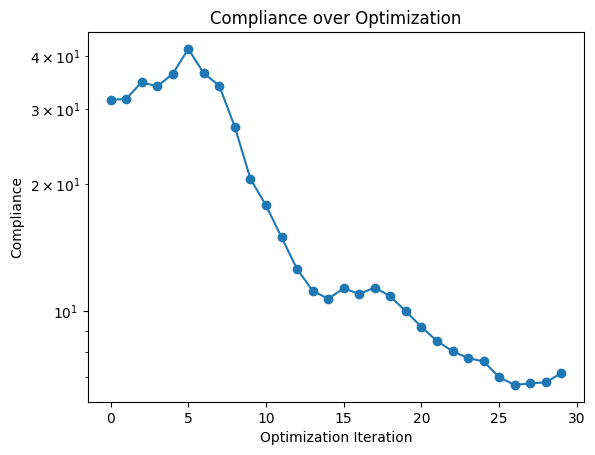

In [148]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [150]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)

In [151]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")